<a href="https://colab.research.google.com/github/NadezhdaMalysheva/projects/blob/main/New_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [226]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Подгружаем необходимые библиотеки 

In [227]:
pip install pytorch-tabnet

In [228]:
import numpy as np
import pandas as pd

In [229]:
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.offline as py
color = sns.color_palette()
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
import plotly.tools as tls

%matplotlib inline

In [230]:
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score 
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
import joblib
from tqdm.notebook import tqdm

from pytorch_tabnet.tab_model import TabNetClassifier

from hyperopt import hp
import numpy as np
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier

import lightgbm as lgb
from hyperopt import fmin, tpe, STATUS_OK, STATUS_FAIL, Trials

from time import time
import joblib

In [231]:
import torch

#Загружаем данные, параметры

In [232]:
def data_preparation(X, y, c=10000, test_size = 0.8):

    X1_train, X1_test, y1_train, y1_test = train_test_split(X[y==1], y[y==1], test_size=test_size, random_state = 43)
    X2_train, X2_test, y2_train, y2_test = train_test_split(X[y==2], y[y==2], test_size=test_size, random_state = 43)
    X3_train, X3_test, y3_train, y3_test = train_test_split(X[y==3], y[y==3], test_size=test_size, random_state = 43)
    
    count = c
    count1 = c

    X_train, X_test = np.concatenate((X1_train[:count], X2_train[:count], X3_train[:count])), np.concatenate((X1_test[:count1], X2_test[:count1], X3_test[:count1]))
    y_train, y_test = np.concatenate((y1_train[:count], y2_train[:count], y3_train[:count])), np.concatenate((y1_test[:count1], y2_test[:count1], y3_test[:count1]))
    

    return [X_train, X_test, y_train, y_test, X1_train, X1_test, y1_train, y1_test, X2_train, X2_test, y2_train, y2_test, X3_train, X3_test, y3_train, y3_test]

In [233]:
def scor(y_test, y_pred):
  return accuracy_score(y_test, y_pred)

lgb_reg_params = {
    'learning_rate':    hp.uniform('learning_rate', 0.001, 0.1),
    'min_child_samples':hp.randint('min_child_samples', 50)+1,
    'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 0.9),
    'num_leaves' :      hp.randint('num_leaves', 100)+10,
    'min_child_weight': hp.uniform('min_child_weight', 0.001, 0.99),
    'n_estimators':     hp.randint('n_estimators', 1500)+100
}
lgb_fit_params = {
    'early_stopping_rounds': 20,
    'verbose': False
}
lgb_para = dict()
lgb_para['reg_params'] = lgb_reg_params
lgb_para['fit_params'] = lgb_fit_params
lgb_para['score'] = lambda y, pred: -accuracy_score(y, pred)


rf_reg_params = {
    'min_samples_leaf': hp.randint('min_samples_leaf', 20)+1,
    'min_samples_split':hp.uniform('min_samples_split', 0.001, 0.1),
    #'max_features':     hp.choice('max_features', ['auto', 'sqrt', 'log2', None]),
    #'learning_rate':    hp.uniform('learning_rate', 0.001, 0.1),
    'n_estimators':     hp.randint('n_estimators', 800)+100
}
rf_fit_params = {
}
rf_para = dict()
rf_para['reg_params'] = rf_reg_params
rf_para['fit_params'] = rf_fit_params
rf_para['score'] = lambda y, pred: -accuracy_score(y, pred)

tabnet_reg_params = {
    'n_d' :              64,
    'n_a' :              64,
    'n_steps' :          hp.randint('n_steps', 10-3)+3,
    'gamma' :            hp.uniform('gamma', 1.0, 3.0),
    'lambda_sparse' :    hp.uniform('lambda_sparse', 0.0, 0.01),
    'momentum' :         0.3, 
    'clip_value' :       2.,
    'optimizer_params' : dict(lr=2e-2),
    'scheduler_params' : {"step_size":50, "gamma":0.9},
    'scheduler_fn' :     torch.optim.lr_scheduler.StepLR,
    'mask_type' :       'entmax'
}

tabnet_fit_params = {
    'max_epochs' : 100, 
    'patience' : 15,
    'batch_size' : 512,
    'virtual_batch_size' : 128,
    'num_workers' : 0,
    'weights' : 1,
    'drop_last' : False,
    #'from_unsupervised' : unsupervised_model
}
tabnet_para = dict()
tabnet_para['reg_params'] = tabnet_reg_params
tabnet_para['fit_params'] = tabnet_fit_params
tabnet_para['score'] = lambda y, pred: -accuracy_score(y, pred)

#Запуск на лучших 10 признаках

In [ ]:
df = joblib.load('/content/drive/MyDrive/Научная работа/Спецсем/TabNetModel/df_agg.pkl')#pd.read_csv('/content/drive/MyDrive/Научная работа/Спецсем/TabNetModel/df_agg.csv')

In [ ]:
feature = columns_not_Err[:-4]
len(feature)

243

In [ ]:
tn = clf

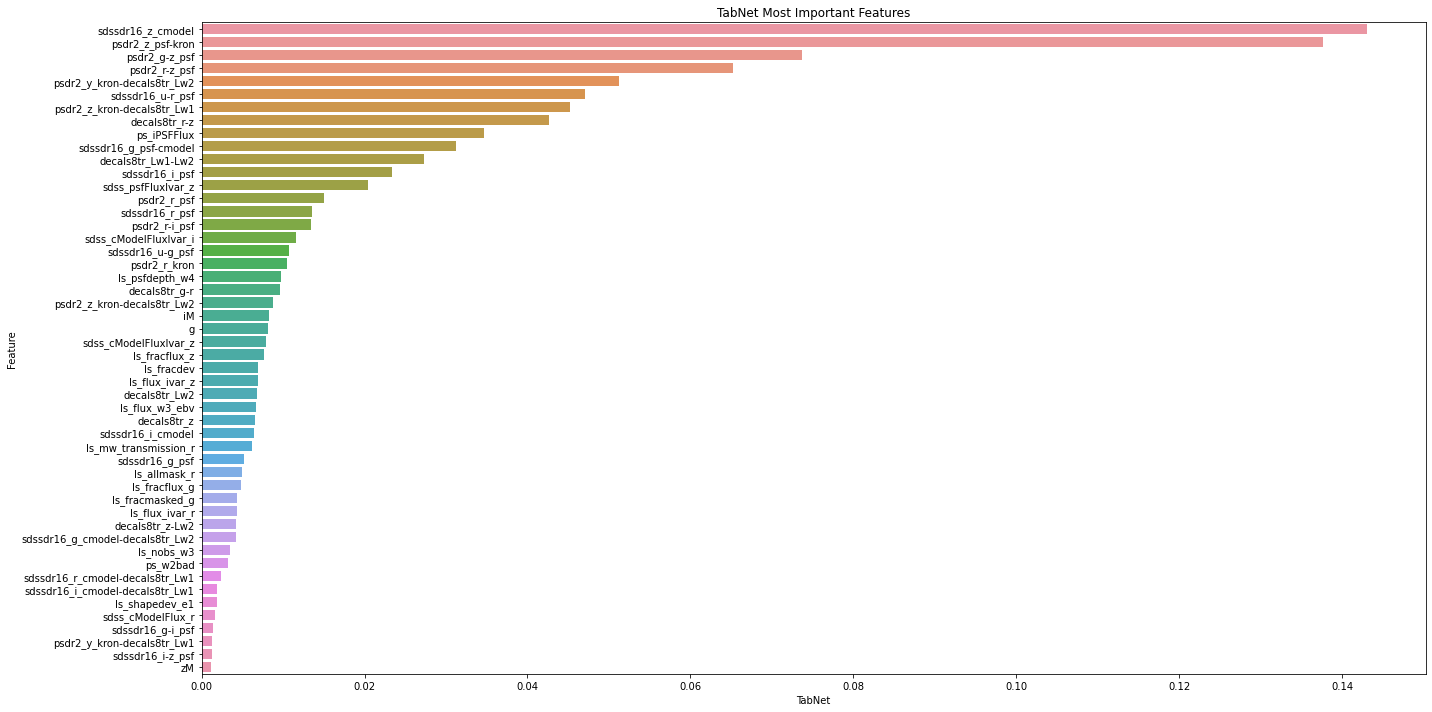

In [ ]:
feature_imp_tn=pd.DataFrame((zip(tn.feature_importances_,feature)), columns=['TabNet','Feature'])
plt.figure(figsize=(20, 10))
sns.barplot(x="TabNet", y="Feature", data=feature_imp_tn.sort_values(by="TabNet", ascending=False).iloc[:50])
plt.title('TabNet Most Important Features')
plt.tight_layout()
plt.show()

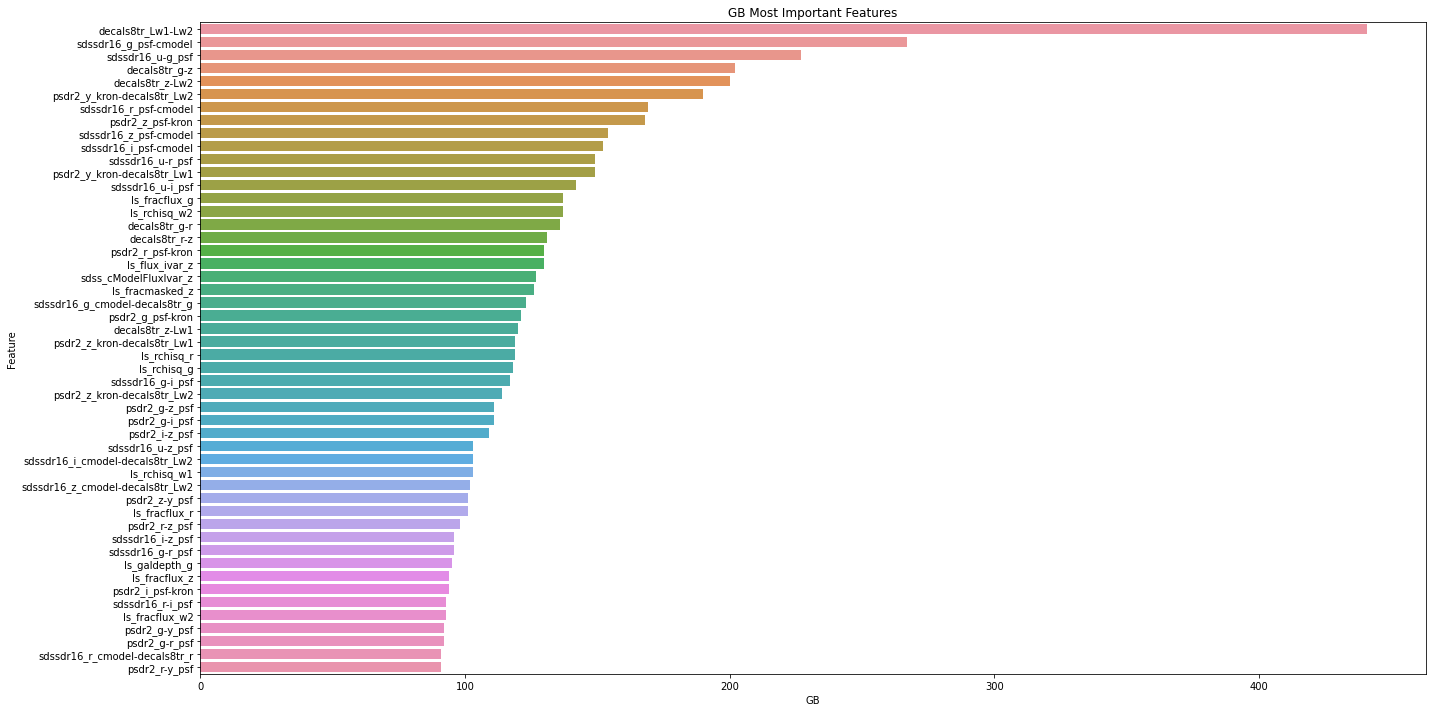

In [ ]:
feature_imp_gb=pd.DataFrame(sorted(zip(gb.feature_importances_, feature)), columns=['GB','Feature'])
plt.figure(figsize=(20, 10))
sns.barplot(x="GB", y="Feature", data=feature_imp_gb.sort_values(by="GB", ascending=False).iloc[:50])
plt.title('GB Most Important Features')
plt.tight_layout()
plt.show()

In [ ]:
t = 5
tn_feature = feature_imp_tn.sort_values(by='TabNet', ascending=False).iloc[:t]['Feature'].values
lgbm_feature = feature_imp_gb.sort_values(by='GB', ascending=False).iloc[:t]['Feature'].values 

In [ ]:
tn_feature, lgbm_feature

(array(['sdssdr16_z_cmodel', 'psdr2_z_psf-kron', 'psdr2_g-z_psf',
        'psdr2_r-z_psf', 'psdr2_y_kron-decals8tr_Lw2'], dtype=object),
 array(['decals8tr_Lw1-Lw2', 'sdssdr16_g_psf-cmodel', 'sdssdr16_u-g_psf',
        'decals8tr_g-z', 'decals8tr_z-Lw2'], dtype=object))

In [ ]:
X_tn = df[tn_feature].dropna().values.astype('float')
X_gb = df[lgbm_feature].dropna().values.astype('float')
y_tn = df.dropna(subset=tn_feature)['Label'].values
y_gb = df.dropna(subset=lgbm_feature)['Label'].values

In [ ]:
X_tn[0], X_gb[0]

(array([20.27505516,  0.28870222,  0.90040168,  0.7980218 ,  2.31764448]),
 array([-0.10055633, -0.00593085,  1.35451829,  1.18279549,  1.73456894]))

In [ ]:
def bootstrap_accuracy(X_test, y_test, X_valid, y_valid):
  from sklearn.utils import resample
  from matplotlib import pyplot
  values = np.concatenate((X_test, y_test.reshape((len(y_test), 1))), axis=1)
  n_iterations = 100
  n_size = int(len(y_test) * 0.50)
  stats = list()
  for i in range(n_iterations):
    train_ind = np.random.randint(0, len(values), n_size)
    test_ind = np.setdiff1d(range(len(values)), train_ind)
    train = values[train_ind]
    test = values[test_ind]
    # fit model
    model = lgb.LGBMClassifier()
    model.fit(train[:,:-1], train[:,-1], eval_set=[(train[:,:-1], train[:,-1]), (X_valid_norm, y_valid)], **lgb_fit_params)
    # evaluate model
    predictions = model.predict(test[:,:-1])
    test = resample(values, n_samples=n_size)
    predictions = model.predict(test[:,:-1])
    score = accuracy_score(test[:,-1], predictions)
    stats.append(score)
  pyplot.hist(stats)
  pyplot.show()
  alpha = 0.8
  p = ((1.0-alpha)/2.0) * 100
  lower = max(0.0, np.percentile(stats, p))
  p = (alpha+((1.0-alpha)/2.0)) * 100
  upper = min(1.0, np.percentile(stats, p))
  print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lower*100, upper*100))
  return stats

##На TabNet

In [ ]:
data_split = data_preparation(X_tn, y_tn+1, 7000, 0.5)

X_train, X_test = data_split[:2]
y_train, y_test = data_split[2:4]

count = 10000

X1_train, X1_test = data_split[4:6]
y1_train, y1_test = data_split[6:8]
X2_train, X2_test = data_split[8:10] 
y2_train, y2_test = data_split[10:12]
X3_train, X3_test = data_split[12:14]
y3_train, y3_test = data_split[14:16]

X_train_pred = np.concatenate((X1_train[count : ], X2_train[count : ], X3_train[count : ])) ###############
X_val_pred   = np.concatenate((X1_test[count : 2*count], X2_test[count : 2*count], X3_test[count : 2*count]))
X_valid      = X_test
y_valid      = y_test

In [ ]:
X_train

array([[15.88255999, -0.12757349,  2.96825592,  1.6595796 , -0.96980746],
       [13.76123206,  0.04121344,  0.70604249,  0.1959566 , -1.77853466],
       [15.40199549, -0.05604527,  1.78139988,  0.80801854, -1.36017438],
       ...,
       [19.6046498 ,  0.24381924,  2.16747637,  1.01552449,  0.47139057],
       [14.72476626,  1.52822381,  1.2339568 ,  0.53733458, -0.8008423 ],
       [16.65903045,  1.30358617,  1.98716351,  0.84824789, -0.13511662]])

In [ ]:
robust = RobustScaler()

X_train_norm = robust.fit_transform(X_train)
X_test_norm = robust.transform(X_test)
X_valid_norm = robust.transform(X_valid)

In [ ]:
gb_check = lgb.LGBMClassifier(n_estimators=10000)
gb_check.fit(X_train_norm, y_train, eval_set=[(X_train_norm, y_train), (X_valid_norm, y_valid)],  **lgb_fit_params)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=10000, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
pred = gb_check.predict(X_test_norm)
print('Classification Report: \n', classification_report(y_test, pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, pred))
gb_train_acc = accuracy_score(y_train, gb_check.predict(X_train_norm))
print('Training Score: ', gb_train_acc)
gb_test_acc =  accuracy_score(y_test, pred)
print('Testing Score: ', gb_test_acc)

Classification Report: 
               precision    recall  f1-score   support

           1       0.98      0.97      0.98      1194
           2       0.98      0.97      0.98      4000
           3       0.95      0.96      0.95      1904

    accuracy                           0.97      7098
   macro avg       0.97      0.97      0.97      7098
weighted avg       0.97      0.97      0.97      7098

Confusion Matrix: 
 [[1164   16   14]
 [  18 3892   90]
 [   8   70 1826]]
Training Score:  0.9861913484570946
Testing Score:  0.9695688926458157


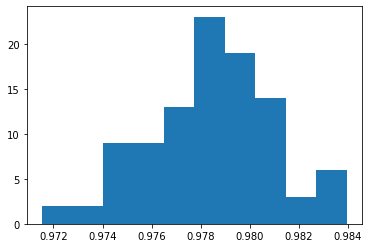

80.0 confidence interval 97.5% and 98.1%


In [ ]:
#tn = joblib.load('/content/drive/MyDrive/Научная работа/Спецсем/TabNetModel/TabNet_model.pkl')
statsTN = bootstrap_accuracy(X_test_norm, y_test, X_valid_norm, y_valid)

##На градиентном бустинге

In [ ]:
data_split = data_preparation(X_gb, y_gb+1, 7000, 0.5)

X_train, X_test = data_split[:2]
y_train, y_test = data_split[2:4]

count = 10000

X1_train, X1_test = data_split[4:6]
y1_train, y1_test = data_split[6:8]
X2_train, X2_test = data_split[8:10] 
y2_train, y2_test = data_split[10:12]
X3_train, X3_test = data_split[12:14]
y3_train, y3_test = data_split[14:16]

X_train_pred = np.concatenate((X1_train[count : ], X2_train[count : ], X3_train[count : ])) ###############
X_val_pred   = np.concatenate((X1_test[count : 2*count], X2_test[count : 2*count], X3_test[count : 2*count]))
X_valid      = X_test
y_valid      = y_test

In [ ]:
robust = RobustScaler()

X_train_norm = robust.fit_transform(X_train)
X_test_norm = robust.transform(X_test)
X_valid_norm = robust.transform(X_valid)

In [ ]:
gb_check = lgb.LGBMClassifier(n_estimators=1000)
gb_check.fit(X_train_norm, y_train, eval_set=[(X_train_norm, y_train), (X_valid_norm, y_valid)],  **lgb_fit_params)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=1000, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
pred = gb_check.predict(X_test_norm)
print('Classification Report: \n', classification_report(y_test, pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, pred))
gb_train_acc = accuracy_score(y_train, gb_check.predict(X_train_norm))
print('Training Score: ', gb_train_acc)
gb_test_acc =  accuracy_score(y_test, pred)
print('Testing Score: ', gb_test_acc)

Classification Report: 
               precision    recall  f1-score   support

           1       0.97      0.96      0.97      1711
           2       0.97      0.97      0.97      4679
           3       0.95      0.95      0.95      2242

    accuracy                           0.96      8632
   macro avg       0.96      0.96      0.96      8632
weighted avg       0.96      0.96      0.96      8632

Confusion Matrix: 
 [[1638   41   32]
 [  32 4558   89]
 [  11  102 2129]]
Training Score:  0.9882952833468537
Testing Score:  0.9644346617238183


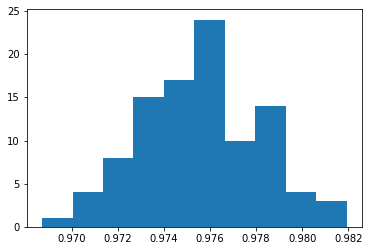

80.0 confidence interval 97.2% and 97.9%


In [ ]:
#gb = joblib.load('/content/drive/MyDrive/Научная работа/Спецсем/TabNetModel/gb_model.pkl')
statsGB = bootstrap_accuracy(X_test_norm, y_test, X_valid_norm, y_valid)

##Сравнение

In [ ]:
stat = pd.DataFrame()
stat['model'] = ['GB']*len(statsGB) + ['TN']*len(statsTN) 
stat['acc'] = statsGB + statsTN 

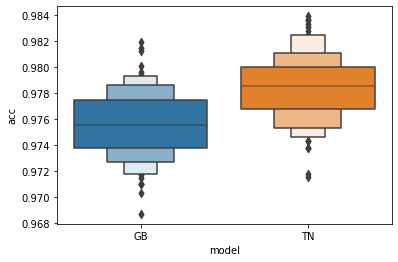

In [ ]:
sns.boxenplot(x='model', y='acc', data=stat)

In [ ]:
gb.booster_.save_model('/content/drive/MyDrive/Научная работа/Data/hyper/gb_x_data.txt')

In [ ]:
tn.save_model('/content/drive/MyDrive/Научная работа/Data/hyper/tn_x_data.txt')

Successfully saved model at /content/drive/MyDrive/Научная работа/Data/hyper/tn_x_data.txt.zip


'/content/drive/MyDrive/Научная работа/Data/hyper/tn_x_data.txt.zip'

In [ ]:
import joblib
# save model
joblib.dump(gb, '/content/drive/MyDrive/Научная работа/Data/hyper/gb_x_data.pkl')
joblib.dump(tn, '/content/drive/MyDrive/Научная работа/Data/hyper/tn_x_data.pkl')


['/content/drive/MyDrive/Научная работа/Data/hyper/tn_x_data.pkl']

# Разделение данных

In [234]:
df_path = '/content/drive/MyDrive/Научная работа/Data/X-ray/x-ray_data_gz.uu'

In [235]:
#with gzip.open(add_data_path, 'rb') as fd:
df = pd.read_pickle(df_path, compression='gzip')

In [236]:
features_path = '/content/drive/MyDrive/Научная работа/Data/features_sdssdr16+psdr2+all_deacls8tr_QSO+GALAXY_20201212133711.pkl'

In [237]:
features = pd.read_pickle(features_path)+ ['LabelQ', 'LabelG', 'LabelS', 'Label']

In [238]:
df = df[features]

In [239]:
df

,sdssdr16_u_psf,sdssdr16_g_psf,sdssdr16_r_psf,sdssdr16_i_psf,sdssdr16_z_psf,sdssdr16_u_cmodel,sdssdr16_i_cmodel,sdssdr16_u-g_psf,sdssdr16_u-r_psf,sdssdr16_u-i_psf,sdssdr16_u-z_psf,sdssdr16_u_psf-cmodel,sdssdr16_g-i_psf,sdssdr16_g_psf-cmodel,sdssdr16_r-i_psf,sdssdr16_i-z_psf,sdssdr16_i_psf-cmodel,sdssdr16_u_cmodel-decals8tr_Lw1,sdssdr16_u_cmodel-decals8tr_Lw2,sdssdr16_g_cmodel-decals8tr_Lw1,sdssdr16_g_cmodel-decals8tr_Lw2,sdssdr16_r_cmodel-decals8tr_Lw1,sdssdr16_r_cmodel-decals8tr_Lw2,sdssdr16_i_cmodel-decals8tr_Lw1,sdssdr16_i_cmodel-decals8tr_Lw2,sdssdr16_z_cmodel-decals8tr_Lw1,sdssdr16_z_cmodel-decals8tr_Lw2,psdr2_i_kron,psdr2_y_kron,psdr2_g_psf,psdr2_r_psf,psdr2_i_psf,psdr2_z_psf,psdr2_y_psf,psdr2_g-i_psf,psdr2_g-y_psf,psdr2_r-i_psf,psdr2_r-y_psf,psdr2_i-z_psf,psdr2_i-y_psf,psdr2_i_psf-kron,psdr2_z-y_psf,psdr2_y_psf-kron,psdr2_g_kron-decals8tr_Lw1,psdr2_g_kron-decals8tr_Lw2,psdr2_r_kron-decals8tr_Lw1,psdr2_r_kron-decals8tr_Lw2,psdr2_i_kron-decals8tr_Lw1,psdr2_i_kron-decals8tr_Lw2,psdr2_z_kron-decals8tr_Lw1,psdr2_z_kron-decals8tr_Lw2,psdr2_y_kron-decals8tr_Lw1,psdr2_y_kron-decals8tr_Lw2,decals8tr_Lw1-Lw2,decals8tr_Lw1,decals8tr_Lw2,decals8tr_g,decals8tr_r,decals8tr_z,decals8tr_g-r,decals8tr_g-z,decals8tr_r-z,sdssdr16_g_cmodel-decals8tr_g,sdssdr16_r_cmodel-decals8tr_r,sdssdr16_z_cmodel-decals8tr_z,LabelQ,LabelG,LabelS,Label
0,22.920023,21.565505,21.621283,21.359891,20.538294,22.769656,21.003623,1.354518,1.298741,1.560132,2.381730,0.150367,0.205614,-0.005931,0.261391,0.821598,0.356269,3.785637,3.685080,2.587416,2.486860,2.554807,2.454250,2.019603,1.919047,1.291036,1.190479,21.665634,21.402220,22.190093,22.087713,21.634099,21.289692,21.402220,0.555995,0.787873,0.453615,0.685493,0.344407,0.231878,-0.031535,-0.112529,0.000000,3.063683,2.963126,3.354069,3.253512,2.681614,2.581058,2.016970,1.916414,2.418201,2.317644,-0.100556,18.984020,19.084576,22.001940,21.912679,20.819145,0.089261,1.182795,1.093534,-0.430505,-0.373853,-0.544090,1,0,0,1
1,19.933288,19.661708,19.533851,19.275093,19.199960,19.896294,19.258232,0.271581,0.399437,0.658195,0.733328,0.036994,0.386615,0.016985,0.258758,0.075133,0.016861,1.332332,1.991179,1.080761,1.739607,0.975765,1.634612,0.694270,1.353117,0.598125,1.256971,19.445711,19.468038,19.991779,19.853252,19.411217,19.369294,19.387387,0.580562,0.604392,0.442035,0.465865,0.041924,0.023830,-0.034493,-0.018094,-0.080650,1.546244,2.205090,1.343668,2.002514,0.881749,1.540595,0.936519,1.595366,0.904076,1.562922,0.658846,18.563962,17.905116,19.511440,19.379499,19.041582,0.131941,0.469858,0.337916,0.133283,0.160229,0.120505,1,0,0,1
2,21.169854,19.856397,19.653011,19.657884,19.544269,21.155460,19.626169,1.313457,1.516843,1.511970,1.625585,0.014394,0.198513,0.015617,-0.004873,0.113615,0.031715,0.910512,1.261518,-0.404168,-0.053162,-0.601723,-0.250717,-0.618778,-0.267773,-0.761571,-0.410565,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.351006,20.244948,19.893942,20.246877,20.167877,20.141632,0.079000,0.105245,0.026245,-0.406098,-0.524652,-0.658255,1,0,0,1
3,21.462910,20.896202,20.697560,20.624691,20.230447,21.543505,20.629416,0.566709,0.765350,0.838219,1.232464,-0.080595,0.271510,-0.013927,0.072869,0.394245,-0.004725,0.952090,1.367123,0.318714,0.733747,0.103659,0.518692,0.038001,0.453034,-0.469909,-0.054876,21.142477,20.489200,21.200060,21.016467,21.097208,20.800597,20.638847,0.102852,0.561213,-0.080741,0.377620,0.296612,0.458361,-0.045269,0.161749,0.149648,0.562941,0.977974,0.525012,0.940045,0.551062,0.966095,0.411343,0.826376,-0.102215,0.312818,0.415033,20.591415,20.176382,21.039786,20.928928,20.674966,0.110858,0.364820,0.253962,-0.129658,-0.233854,-0.553460,1,0,0,1
4,21.807372,21.333804,21.339532,21.396991,20.997808,21.747126,21.271441,0.473568,0.467840,0.410380,0.809564,0.060246,-0.063188,0.020335,-0.057459,0.399184,0.125550,1.675917,2.307175,1.242260,1.873518,1.243229,1.874486,1.200232,1.831490,0.755095,1.386353,21.795659,20.986745,21.709883,21.645918,21.47594

In [240]:
df_s = df[df.Label==0]
df_q = df[df.Label==1]
df_g = df[df.Label==2]

In [241]:
df_s

,sdssdr16_u_psf,sdssdr16_g_psf,sdssdr16_r_psf,sdssdr16_i_psf,sdssdr16_z_psf,sdssdr16_u_cmodel,sdssdr16_i_cmodel,sdssdr16_u-g_psf,sdssdr16_u-r_psf,sdssdr16_u-i_psf,sdssdr16_u-z_psf,sdssdr16_u_psf-cmodel,sdssdr16_g-i_psf,sdssdr16_g_psf-cmodel,sdssdr16_r-i_psf,sdssdr16_i-z_psf,sdssdr16_i_psf-cmodel,sdssdr16_u_cmodel-decals8tr_Lw1,sdssdr16_u_cmodel-decals8tr_Lw2,sdssdr16_g_cmodel-decals8tr_Lw1,sdssdr16_g_cmodel-decals8tr_Lw2,sdssdr16_r_cmodel-decals8tr_Lw1,sdssdr16_r_cmodel-decals8tr_Lw2,sdssdr16_i_cmodel-decals8tr_Lw1,sdssdr16_i_cmodel-decals8tr_Lw2,sdssdr16_z_cmodel-decals8tr_Lw1,sdssdr16_z_cmodel-decals8tr_Lw2,psdr2_i_kron,psdr2_y_kron,psdr2_g_psf,psdr2_r_psf,psdr2_i_psf,psdr2_z_psf,psdr2_y_psf,psdr2_g-i_psf,psdr2_g-y_psf,psdr2_r-i_psf,psdr2_r-y_psf,psdr2_i-z_psf,psdr2_i-y_psf,psdr2_i_psf-kron,psdr2_z-y_psf,psdr2_y_psf-kron,psdr2_g_kron-decals8tr_Lw1,psdr2_g_kron-decals8tr_Lw2,psdr2_r_kron-decals8tr_Lw1,psdr2_r_kron-decals8tr_Lw2,psdr2_i_kron-decals8tr_Lw1,psdr2_i_kron-decals8tr_Lw2,psdr2_z_kron-decals8tr_Lw1,psdr2_z_kron-decals8tr_Lw2,psdr2_y_kron-decals8tr_Lw1,psdr2_y_kron-decals8tr_Lw2,decals8tr_Lw1-Lw2,decals8tr_Lw1,decals8tr_Lw2,decals8tr_g,decals8tr_r,decals8tr_z,decals8tr_g-r,decals8tr_g-z,decals8tr_r-z,sdssdr16_g_cmodel-decals8tr_g,sdssdr16_r_cmodel-decals8tr_r,sdssdr16_z_cmodel-decals8tr_z,LabelQ,LabelG,LabelS,Label
14095,22.205799,20.147787,19.289909,18.977191,18.667902,20.895187,18.822989,2.058012,2.915890,3.228608,3.537898,1.310613,1.170596,0.061094,0.312718,0.309289,0.154202,1.974550,1.960860,1.166056,1.152367,0.305213,0.291523,-0.097648,-0.111338,-0.425530,-0.439219,18.920448,18.628564,20.006031,19.303136,18.975600,18.842633,18.759075,1.030431,1.246956,0.327537,0.544061,0.132967,0.216524,0.055151,0.083557,0.130512,1.094189,1.080499,0.366355,0.352666,-0.000189,-0.013878,-0.220647,-0.234337,-0.292073,-0.305763,-0.013689,18.920637,18.934326,20.042944,19.211602,18.759660,0.831342,1.283285,0.451942,0.043749,0.014248,-0.264553,0,0,1,0
14096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0
14097,19.140804,17.888408,17.442821,17.247753,17.171994,19.147438,17.253295,1.252396,1.697983,1.893051,1.968810,-0.006634,0.640655,0.004969,0.195068,0.075759,-0.005543,0.812691,0.243831,-0.451308,-1.020168,-0.904510,-1.473370,-1.081452,-1.650312,-1.157631,-1.726491,17.361251,17.204722,17.837975,17.269408,17.273035,17.220647,17.180256,0.564940,0.657720,-0.003628,0.089152,0.052388,0.092780,-0.088216,0.040392,-0.024467,-0.439107,-1.007967,-0.855828,-1.424688,-0.973496,-1.542356,-1.032787,-1.601647,-1.130025,-1.698885,-0.568860,18.334747,18.903607,17.828840,17.366467,17.176663,0.462373,0.652177,0.189804,0.054600,0.063770,0.000453,0,0,1,0
14098,19.882465,18.527261,17.841124,17.628888,17.428524,19.862783,17.609165,1.355204,2.041341,2.253578,2.453942,0.019683,0.898374,0.021378,0.212236,0.200364,0.019722,1.320175,0.703110,-0.036724,-0.653789,-0.703643,-1.320707,-0.933443,-1.550507,-1.096180,-1.713245,17.709008,17.603952,18.415109,17.840860,17.702549,17.514029,17.457911,0.712560,0.957198,0.138311,0.382949,0.188521,0.244638,-0.006458,0.056118,-0.146041,-0.078471,-0.695536,-0.648537,-1.265601,-0.833600,-1.450665,-0.923954,-1.541018,-0.938655,-1.555720,-0.617064,18.542608,19.159672,18.420719,17.778269,17.500613,0.642449,0.920105,0.277656,0.085165,0.060696,-0.054186,0,0,1,0
14099,20.980263,18.559502,17.500689,17.085194,16.828653,20.862707,17.077459,2.420761,3.479574,3.895069,4.151611,0.117557,1.474308,-0.001674,0.415495,0.256542,0.007735,3.275773,2.688127,0.974243,0.386598,-0.101355,-0.689001,-0.509474,-1.097120,-0.745986,-1.333632,17.155033,16.890206,18.422798,17.450494,17.080503,16.921963,16.856364,1.342295,1.566434,0.369991,0.594130,0.158539,0.224139,-0.074530,0.065600,-0.033843,0.907575,0.319929,-0.051811,-0.639456,-0.431901,-1.0

(5917, 69) (9533, 69) (4562, 69)


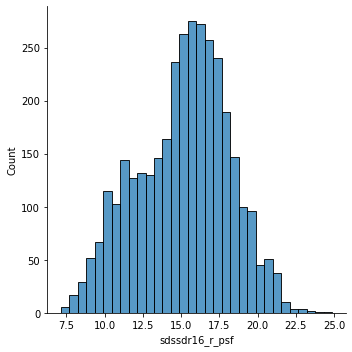

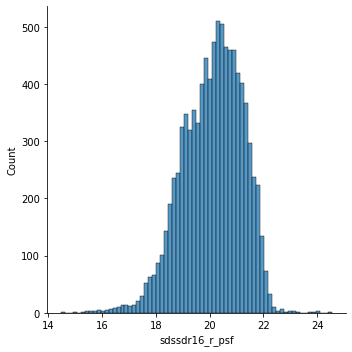

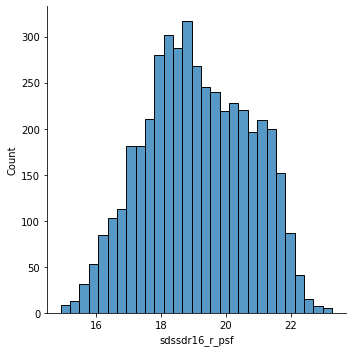

In [242]:
sns.displot(df_s.sdssdr16_r_psf)
sns.displot(df_q.sdssdr16_r_psf)
sns.displot(df_g.sdssdr16_r_psf)
print(df_s.shape, df_q.shape, df_g.shape)

In [243]:
def data_split(df_all, column='sdssdr16_r_psf', label='Label'):
  df = df_all.sort_values('sdssdr16_r_psf')
  def split(df_loc, c=9000):
    data = df_loc.drop(['LabelQ', 'LabelG', 'LabelS', 'Label'], axis = 1).values
    data1 = data[::2]
    data2 = data[1::2]
    print(data, data1, data2)
    np.random.shuffle(data1)
    np.random.shuffle(data2)
    return data1[:c//2], data2[:c//2]

  def train_test(X1, X2, X3, test_size=0.1):
    X1_train, X1_test, y1_train, y1_test = train_test_split(X1, 1*np.ones([len(X1), 1]), test_size=test_size, random_state = 43)
    X2_train, X2_test, y2_train, y2_test = train_test_split(X2, 2*np.ones([len(X2), 1]), test_size=test_size, random_state = 43)
    X3_train, X3_test, y3_train, y3_test = train_test_split(X3, 3*np.ones([len(X3), 1]), test_size=test_size, random_state = 43)

    X_train, X_test = np.concatenate((X1_train, X2_train, X3_train)), np.concatenate((X1_test, X2_test, X3_test))
    y_train, y_test = np.concatenate((y1_train, y2_train, y3_train)), np.concatenate((y1_test, y2_test, y3_test))
        
    train = np.concatenate((X_train, y_train.rashape((len(X_train), 1))))
    test = np.concatenate((X_test, y_test.rashape((len(X_test), 1))))

    return train, test
    
  df_s = df[df[label]==0]
  df_q = df[df[label]==1]
  df_g = df[df[label]==2]

  c = np.min((len(df_s), len(df_q), len(df_g)))


  X1_s , X2_s = split(df_s)
  X1_q , X2_q = split(df_q)
  X1_g , X2_g = split(df_g)


  X1 = np.concatenate((np.concatenate((X1_s, 1*np.ones([len(X1_s), 1])), axis=1),
                       np.concatenate((X1_q, 2*np.ones([len(X1_q), 1])), axis=1),
                       np.concatenate((X1_g, 3*np.ones([len(X1_g), 1])), axis=1)),
                      axis=0)
  X2 = np.concatenate((np.concatenate((X2_s, 1*np.ones([len(X2_s), 1])), axis=1),
                       np.concatenate((X2_q, 2*np.ones([len(X2_q), 1])), axis=1),
                       np.concatenate((X2_g, 3*np.ones([len(X2_g), 1])), axis=1)),
                      axis=0)
  
  np.random.shuffle(X1)
  np.random.shuffle(X2)

  return X1, X2#train1, train2, test1, test2

In [ ]:
data1, data2 = data_split(df.dropna())

In [245]:
df

,sdssdr16_u_psf,sdssdr16_g_psf,sdssdr16_r_psf,sdssdr16_i_psf,sdssdr16_z_psf,sdssdr16_u_cmodel,sdssdr16_i_cmodel,sdssdr16_u-g_psf,sdssdr16_u-r_psf,sdssdr16_u-i_psf,sdssdr16_u-z_psf,sdssdr16_u_psf-cmodel,sdssdr16_g-i_psf,sdssdr16_g_psf-cmodel,sdssdr16_r-i_psf,sdssdr16_i-z_psf,sdssdr16_i_psf-cmodel,sdssdr16_u_cmodel-decals8tr_Lw1,sdssdr16_u_cmodel-decals8tr_Lw2,sdssdr16_g_cmodel-decals8tr_Lw1,sdssdr16_g_cmodel-decals8tr_Lw2,sdssdr16_r_cmodel-decals8tr_Lw1,sdssdr16_r_cmodel-decals8tr_Lw2,sdssdr16_i_cmodel-decals8tr_Lw1,sdssdr16_i_cmodel-decals8tr_Lw2,sdssdr16_z_cmodel-decals8tr_Lw1,sdssdr16_z_cmodel-decals8tr_Lw2,psdr2_i_kron,psdr2_y_kron,psdr2_g_psf,psdr2_r_psf,psdr2_i_psf,psdr2_z_psf,psdr2_y_psf,psdr2_g-i_psf,psdr2_g-y_psf,psdr2_r-i_psf,psdr2_r-y_psf,psdr2_i-z_psf,psdr2_i-y_psf,psdr2_i_psf-kron,psdr2_z-y_psf,psdr2_y_psf-kron,psdr2_g_kron-decals8tr_Lw1,psdr2_g_kron-decals8tr_Lw2,psdr2_r_kron-decals8tr_Lw1,psdr2_r_kron-decals8tr_Lw2,psdr2_i_kron-decals8tr_Lw1,psdr2_i_kron-decals8tr_Lw2,psdr2_z_kron-decals8tr_Lw1,psdr2_z_kron-decals8tr_Lw2,psdr2_y_kron-decals8tr_Lw1,psdr2_y_kron-decals8tr_Lw2,decals8tr_Lw1-Lw2,decals8tr_Lw1,decals8tr_Lw2,decals8tr_g,decals8tr_r,decals8tr_z,decals8tr_g-r,decals8tr_g-z,decals8tr_r-z,sdssdr16_g_cmodel-decals8tr_g,sdssdr16_r_cmodel-decals8tr_r,sdssdr16_z_cmodel-decals8tr_z,LabelQ,LabelG,LabelS,Label
0,22.920023,21.565505,21.621283,21.359891,20.538294,22.769656,21.003623,1.354518,1.298741,1.560132,2.381730,0.150367,0.205614,-0.005931,0.261391,0.821598,0.356269,3.785637,3.685080,2.587416,2.486860,2.554807,2.454250,2.019603,1.919047,1.291036,1.190479,21.665634,21.402220,22.190093,22.087713,21.634099,21.289692,21.402220,0.555995,0.787873,0.453615,0.685493,0.344407,0.231878,-0.031535,-0.112529,0.000000,3.063683,2.963126,3.354069,3.253512,2.681614,2.581058,2.016970,1.916414,2.418201,2.317644,-0.100556,18.984020,19.084576,22.001940,21.912679,20.819145,0.089261,1.182795,1.093534,-0.430505,-0.373853,-0.544090,1,0,0,1
1,19.933288,19.661708,19.533851,19.275093,19.199960,19.896294,19.258232,0.271581,0.399437,0.658195,0.733328,0.036994,0.386615,0.016985,0.258758,0.075133,0.016861,1.332332,1.991179,1.080761,1.739607,0.975765,1.634612,0.694270,1.353117,0.598125,1.256971,19.445711,19.468038,19.991779,19.853252,19.411217,19.369294,19.387387,0.580562,0.604392,0.442035,0.465865,0.041924,0.023830,-0.034493,-0.018094,-0.080650,1.546244,2.205090,1.343668,2.002514,0.881749,1.540595,0.936519,1.595366,0.904076,1.562922,0.658846,18.563962,17.905116,19.511440,19.379499,19.041582,0.131941,0.469858,0.337916,0.133283,0.160229,0.120505,1,0,0,1
2,21.169854,19.856397,19.653011,19.657884,19.544269,21.155460,19.626169,1.313457,1.516843,1.511970,1.625585,0.014394,0.198513,0.015617,-0.004873,0.113615,0.031715,0.910512,1.261518,-0.404168,-0.053162,-0.601723,-0.250717,-0.618778,-0.267773,-0.761571,-0.410565,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.351006,20.244948,19.893942,20.246877,20.167877,20.141632,0.079000,0.105245,0.026245,-0.406098,-0.524652,-0.658255,1,0,0,1
3,21.462910,20.896202,20.697560,20.624691,20.230447,21.543505,20.629416,0.566709,0.765350,0.838219,1.232464,-0.080595,0.271510,-0.013927,0.072869,0.394245,-0.004725,0.952090,1.367123,0.318714,0.733747,0.103659,0.518692,0.038001,0.453034,-0.469909,-0.054876,21.142477,20.489200,21.200060,21.016467,21.097208,20.800597,20.638847,0.102852,0.561213,-0.080741,0.377620,0.296612,0.458361,-0.045269,0.161749,0.149648,0.562941,0.977974,0.525012,0.940045,0.551062,0.966095,0.411343,0.826376,-0.102215,0.312818,0.415033,20.591415,20.176382,21.039786,20.928928,20.674966,0.110858,0.364820,0.253962,-0.129658,-0.233854,-0.553460,1,0,0,1
4,21.807372,21.333804,21.339532,21.396991,20.997808,21.747126,21.271441,0.473568,0.467840,0.410380,0.809564,0.060246,-0.063188,0.020335,-0.057459,0.399184,0.125550,1.675917,2.307175,1.242260,1.873518,1.243229,1.874486,1.200232,1.831490,0.755095,1.386353,21.795659,20.986745,21.709883,21.645918,21.47594

In [246]:
X1, y1 = data1[:,:-1], data1[:,-1].astype('int')
X2, y2 = data1[:,:-1], data1[:,-1].astype('int')

In [247]:
X1.shape

(7046, 65)

# Обучаем на первой выборке, проверяем на второй

In [248]:
data_split = data_preparation(X1, y1, 5000, 0.1)#joblib.load('/content/drive/MyDrive/Научная работа/Спецсем/TabNetModel/data_split.pkl')

X_train, X_test = data_split[:2]
y_train, y_test = data_split[2:4]

train = np.concatenate((X_train, y_train.reshape((len(y_train), 1))), axis=1)
np.random.shuffle(train)
X_train, y_train = train[:,:-1], train[:,-1].astype('int')

count = 100000

X1_train, X1_test = data_split[4:6]
y1_train, y1_test = data_split[6:8]
X2_train, X2_test = data_split[8:10] 
y2_train, y2_test = data_split[10:12]
X3_train, X3_test = data_split[12:14]
y3_train, y3_test = data_split[14:16]

X_train_pred = np.concatenate((X1_test[2*count : 4*count], X2_test[2*count : 4*count], X3_test[2*count : 4*count])) ###############
X_val_pred   = np.concatenate((X1_test[count : 2*count], X2_test[count : 2*count], X3_test[count : 2*count]))
np.random.shuffle(X_train_pred)
np.random.shuffle(X_val_pred)

X_valid      = X_test
y_valid      = y_test

In [249]:
robust = RobustScaler()

X_train_norm = robust.fit_transform(X_train)
X_test_norm = robust.transform(X_test)

X_valid_norm = robust.transform(X_valid)

In [250]:
X_train.shape

(6340, 65)

In [251]:
gb = lgb.LGBMClassifier()
t = time()
gb.fit(X_train_norm, y_train, eval_set=[(X_train_norm, y_train), (X_test_norm, y_test)],  **lgb_fit_params)
print(time()-t)

1.1480119228363037


In [252]:
pred = gb.predict(X_test_norm)
print('Classification Report: \n', classification_report(y_test, pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, pred))
gb_train_acc = accuracy_score(y_train, gb.predict(X_train_norm))
print('Training Score: ', gb_train_acc)
gb_test_acc =  accuracy_score(y_test, pred)
print('Testing Score: ', gb_test_acc)

Classification Report: 
               precision    recall  f1-score   support

           1       0.98      0.93      0.96       116
           2       0.96      0.97      0.97       400
           3       0.94      0.94      0.94       190

    accuracy                           0.96       706
   macro avg       0.96      0.95      0.95       706
weighted avg       0.96      0.96      0.96       706

Confusion Matrix: 
 [[108   5   3]
 [  1 390   9]
 [  1  10 179]]
Training Score:  0.9970031545741325
Testing Score:  0.9589235127478754


In [253]:
X_train.shape, X_test.shape

((6340, 65), (706, 65))

In [254]:
clf = TabNetClassifier(n_d=8, n_a=8,
                       momentum=0.7,
                       optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=2e-2),
                       scheduler_params={"step_size":200, # how to use learning rate scheduler
                                         "gamma":0.95},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,

                       mask_type='entmax',
                       **{'gamma': 1.7,
                          'lambda_sparse': 0.001,
                          'n_steps': 3}

)

Device used : cuda


In [255]:
max_epochs = 2000

In [256]:
X_train.shape

(6340, 65)

In [257]:
X_test.shape

(706, 65)

In [258]:
t = time()
clf.fit(
    X_train=X_train, y_train=y_train,
    #X_valid=X_valid, y_valid=y_valid,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_name=['train', 'valid'],
    eval_metric=['logloss','accuracy'],
    max_epochs=max_epochs , patience=20,
    batch_size=512, virtual_batch_size=64,
    #from_unsupervised=unsupervised_model
) 
print(time()-t)

epoch 0  | loss: 0.92474 | train_logloss: 3.43286 | train_accuracy: 0.67192 | valid_logloss: 3.30555 | valid_accuracy: 0.67989 |  0:00:01s
epoch 1  | loss: 0.38003 | train_logloss: 1.95185 | train_accuracy: 0.46404 | valid_logloss: 1.88921 | valid_accuracy: 0.45184 |  0:00:01s
epoch 2  | loss: 0.22707 | train_logloss: 2.48949 | train_accuracy: 0.66877 | valid_logloss: 2.33404 | valid_accuracy: 0.67705 |  0:00:02s
epoch 3  | loss: 0.17055 | train_logloss: 2.47091 | train_accuracy: 0.32382 | valid_logloss: 2.36671 | valid_accuracy: 0.30595 |  0:00:02s
epoch 4  | loss: 0.16006 | train_logloss: 3.21318 | train_accuracy: 0.29968 | valid_logloss: 3.22221 | valid_accuracy: 0.28754 |  0:00:03s
epoch 5  | loss: 0.1563  | train_logloss: 1.27542 | train_accuracy: 0.51167 | valid_logloss: 1.20103 | valid_accuracy: 0.51841 |  0:00:04s
epoch 6  | loss: 0.15336 | train_logloss: 0.9124  | train_accuracy: 0.72744 | valid_logloss: 0.90326 | valid_accuracy: 0.71955 |  0:00:04s
epoch 7  | loss: 0.14206 | 

In [ ]:
X_test = X_test.astype('float')

In [ ]:
pred = clf.predict(X_test)
print('Classification Report: \n', classification_report(y_test, pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, pred))
clf_train_acc = accuracy_score(y_train, clf.predict(X_train.astype('float')))
print('Training Score: ', clf_train_acc)
clf_test_acc = accuracy_score(y_test, pred)
print('Training Score: ', clf_test_acc)

Classification Report: 
               precision    recall  f1-score   support

           1       0.98      0.97      0.98      1046
           2       0.98      0.97      0.98      3462
           3       0.95      0.98      0.96      1697

    accuracy                           0.97      6205
   macro avg       0.97      0.97      0.97      6205
weighted avg       0.97      0.97      0.97      6205

Confusion Matrix: 
 [[1017   19   10]
 [  12 3367   83]
 [   5   36 1656]]
Training Score:  0.9777562862669246
Training Score:  0.9734085414987913


In [225]:
lgb_fit_params = {
    'early_stopping_rounds': 20,
    'verbose': False
}
lgb_class_params = {
    'min_child_samples':np.random.randint(1, 50, size = 5),
    'colsample_bytree': np.random.uniform(0.1, 0.9, size = 5),
    'num_leaves' :      np.random.randint(10, 100, size = 5),
    'min_child_weight': np.random.uniform(0.001, 0.99, size = 5),
}

kf = KFold(n_splits=3)

LGBM = RandomizedSearchCV(LGBMClassifier(learning_rate=0.001, n_estimators=1000), lgb_class_params, random_state=0, cv=kf)
search = LGBM.fit(X_train_norm, y_train)

In [ ]:
X_test.shape

(8669, 26)

In [ ]:
len(gb.feature_importances_)

26

In [ ]:
np.where(gb.feature_importances_ == 366)[0].tolist()

[]

In [ ]:
[columns_sdss[i] for i in np.where(gb.feature_importances_ == 930)[0].tolist()]

['sdssdr16_u-z_psf']

In [ ]:
columns_not_ls = [i for i in columns_not_L if 'ls' not in i]

In [ ]:
columns_not_Err =  [i for i in columns if 'Err' not in i]

In [ ]:
columns_not_Ivar = [i for i in columns_not_Err if 'Ivar' not in i]

In [ ]:
columns_not_w = [i for i in columns_not_Ivar if 'w' not in i]

In [ ]:
columns_sdss = [i for i in columns_not_Ivar if 'sdss' in i] + ['LabelQ', 'LabelG', 'LabelS', 'Label']

In [ ]:
columns_not_z = [i for i in columns_sdss if 'z' not in i]

In [ ]:
columns_not_z

['sdss_cModelFlux_u',
 'sdss_cModelFlux_g',
 'sdss_cModelFlux_r',
 'sdss_cModelFlux_i',
 'sdss_psfFlux_u',
 'sdss_psfFlux_g',
 'sdss_psfFlux_r',
 'sdss_psfFlux_i',
 'sdssdr16_u_psf',
 'sdssdr16_g_psf',
 'sdssdr16_r_psf',
 'sdssdr16_i_psf',
 'sdssdr16_u_cmodel',
 'sdssdr16_g_cmodel',
 'sdssdr16_r_cmodel',
 'sdssdr16_i_cmodel',
 'sdssdr16_u-g_psf',
 'sdssdr16_u-r_psf',
 'sdssdr16_u-i_psf',
 'sdssdr16_u_psf-cmodel',
 'sdssdr16_g-r_psf',
 'sdssdr16_g-i_psf',
 'sdssdr16_g_psf-cmodel',
 'sdssdr16_r-i_psf',
 'sdssdr16_r_psf-cmodel',
 'sdssdr16_i_psf-cmodel',
 'LabelQ',
 'LabelG',
 'LabelS',
 'Label']